In [1]:
# Import libraries
import torch
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Pytorch related

from torchvision import datasets
from torchvision.transforms import transforms
from torch.utils.data.sampler import SubsetRandomSampler

import torch.nn as nn 
import torch.nn.functional as F 
import torch.optim as optim

In [4]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [5]:
# Transforms

train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomRotation(45),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

In [8]:
# trqain and test datasets

train_data = datasets.CIFAR10('~/datasets/CIFAR10_data/', train = True, download=True, transform=train_transform)

test_data =  datasets.CIFAR10('~/datasets/CIFAR10_data/', train = False, download=True, transform=train_transform)

Files already downloaded and verified
Files already downloaded and verified


In [13]:
# number of subprocesses for data loading
num_workers = 2
# how many samples per batch to load
batch_size = 32
# percentage of training set to use as validation
valid_size = 0.2

In [14]:
# train indices for validation

num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

In [15]:
# samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

In [16]:

# data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers)

In [17]:
# image classes
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

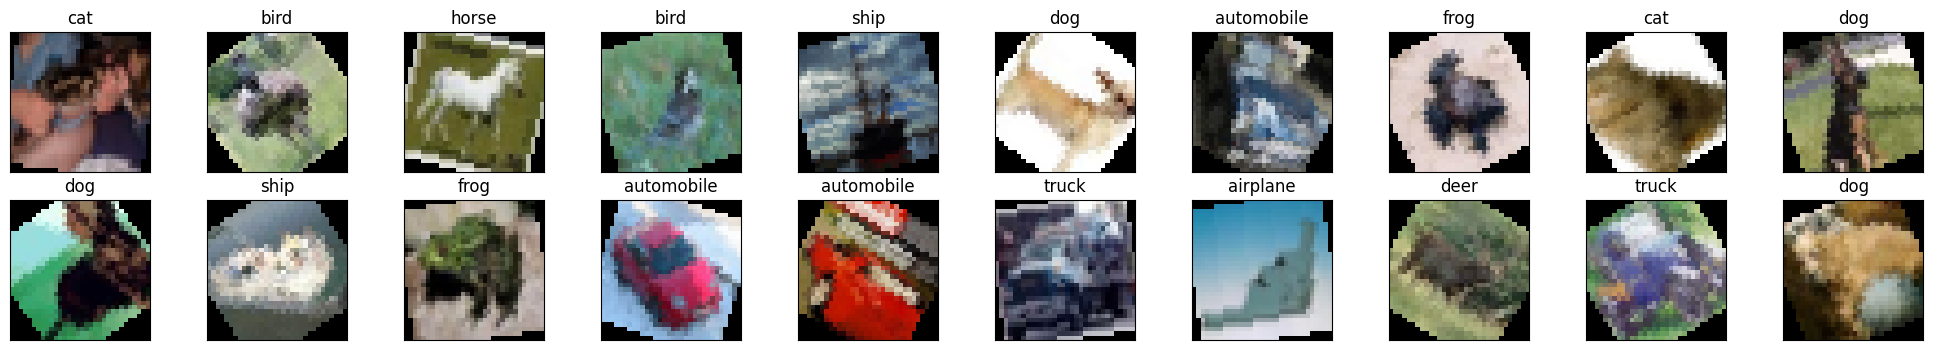

In [20]:
# Visualizing a batch of data

def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image



# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
images = images.numpy() # convert images to numpy for display
images.shape


fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20//2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

In [23]:
# Defining the network


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32,64, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 64, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)

        self.fc1 = nn.Linear(64 * 8 * 8,  64)
        self.bn4 = nn.BatchNorm1d(64)
        self.fc2 = nn.Linear(64, 10)

        self.dropout = nn.Dropout(0.3)        

    def forward(self, x):

        x = F.relu(self.bn1(self.conv1(x)))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.bn3(self.conv3(x)))

        x = x.view(x.size(0), -1)
        x = F.relu(self.bn4(self.fc1(x)))
        x = self.dropout(x)
        x = self.fc2(x)

        return x

In [24]:
# model

model = Net()
model

Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=4096, out_features=64, bias=True)
  (bn4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=64, out_features=10, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

In [25]:
# move tensors to GPU if CUDA is available
if train_on_gpu:
    model.cuda()

In [31]:
# loss function
criterion = nn.CrossEntropyLoss()

# optimizer
optimizer = optim.SGD(model.parameters(), lr = 0.001)

In [32]:
# train


n_epochs = 30

valid_loss_min = np.inf

if train_on_gpu:
    print("Trainign on GPU!")


for epoch in range(1, n_epochs+1):

    train_loss = 0
    valid_loss = 0

    model.train()


    for data, target in train_loader:

        if train_on_gpu:
            data, target = data.cuda(), target.cuda()

        # clear the gradient
        optimizer.zero_grad()
        # forward pass
        output = model(data)
        # loss
        loss = criterion(output, target)

        # backward pass
        loss.backward()

        optimizer.step()

        train_loss += loss.item() * data.size(0)


    # validation

    model.eval()

    for data, target in valid_loader:

        if train_on_gpu:
            data, target = data.cuda(), target.cuda()

        # forward pass
        output = model(data)

        loss = criterion(output, target)
        valid_loss += loss.item()*data.size(0)

    
    # average losses 
    train_loss = train_loss / len(train_loader.sampler)
    valid_loss = valid_loss / len(valid_loader.sampler)


    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), './model_cifar.pt')
        valid_loss_min = valid_loss

Trainign on GPU!
Epoch: 1 	Training Loss: 0.782552 	Validation Loss: 0.749177
Validation loss decreased (inf --> 0.749177).  Saving model ...
Epoch: 2 	Training Loss: 0.767614 	Validation Loss: 0.745089
Validation loss decreased (0.749177 --> 0.745089).  Saving model ...
Epoch: 3 	Training Loss: 0.763838 	Validation Loss: 0.740443
Validation loss decreased (0.745089 --> 0.740443).  Saving model ...
Epoch: 4 	Training Loss: 0.768625 	Validation Loss: 0.734006
Validation loss decreased (0.740443 --> 0.734006).  Saving model ...
Epoch: 5 	Training Loss: 0.754408 	Validation Loss: 0.737857
Epoch: 6 	Training Loss: 0.756318 	Validation Loss: 0.727108
Validation loss decreased (0.734006 --> 0.727108).  Saving model ...
Epoch: 7 	Training Loss: 0.761349 	Validation Loss: 0.717595
Validation loss decreased (0.727108 --> 0.717595).  Saving model ...
Epoch: 8 	Training Loss: 0.751103 	Validation Loss: 0.726330
Epoch: 9 	Training Loss: 0.749696 	Validation Loss: 0.721862
Epoch: 10 	Training Loss:

In [33]:
# Testing the model



model.load_state_dict(torch.load('./model_cifar.pt'))

# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval()


for data, target in test_loader:

    if train_on_gpu:
        data, target = data.cuda(), target.cuda()

    output = model(data)

    loss = criterion(output, target)

    test_loss += loss.item()*data.size(0)

    _, pred = torch.max(output, 1)    
    
    correct_tensor = pred.eq(target.data.view_as(pred))

    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())

    current_batch_size = data.size(0)
        
        # Only iterate over the actual batch size
    for i in range(current_batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

    # average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))






Test Loss: 0.714650

Test Accuracy of airplane: 77% (779/1000)
Test Accuracy of automobile: 84% (848/1000)
Test Accuracy of  bird: 65% (655/1000)
Test Accuracy of   cat: 56% (566/1000)
Test Accuracy of  deer: 70% (702/1000)
Test Accuracy of   dog: 69% (692/1000)
Test Accuracy of  frog: 83% (830/1000)
Test Accuracy of horse: 78% (785/1000)
Test Accuracy of  ship: 84% (842/1000)
Test Accuracy of truck: 80% (809/1000)

Test Accuracy (Overall): 75% (7508/10000)
